# CS-E4600 — Programming project

## Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.cluster.vq import vq, kmeans, whiten

## Read file

In [26]:
#file = 'test'
#file = 'ca-GrQc'
file = 'Oregon-1'

## Read First line info and Edges

In [27]:
folder = './graphs_processed/'
with open(folder + file + '.txt') as f:
    first_line = f.readline()

splitted = first_line.split()

num_nodes = int(splitted[2])
num_edges = int(splitted[3])
k = int(splitted[4])
print(num_nodes, num_edges, k)

    
pd_edges = pd.read_csv(folder + file + '.txt', sep=" ", skiprows=range(0, 1), header=None)
pd_edges.columns = ["FromNodeId","ToNodeId"]
#pd_edges

10670 22002 5


## Select Distinct Nodes

In [28]:
node_candidates_1 = pd_edges.drop_duplicates(subset="FromNodeId")["FromNodeId"]
node_candidates_2 = pd_edges.drop_duplicates(subset="ToNodeId")["ToNodeId"]

In [29]:
pd_nodes = pd.concat([node_candidates_1, node_candidates_2])
pd_nodes = pd_nodes.drop_duplicates()
#pd_nodes

## Convert Nodes and Edges to Numpy

In [30]:
nodes = pd_nodes.values
edges = pd_edges.values
nodes2 = np.arange(num_nodes)
#print(nodes.shape, nodes.shape)
print(nodes)
print(nodes2)
nodes = nodes2
#nodes.shape, edges.shape

[    0     1     2 ... 10470 10311 10412]
[    0     1     2 ... 10667 10668 10669]


## Create Adjacency Matrix

what to do with too big arrays??

In [31]:
adjacency_matrix = np.zeros((nodes.size, nodes.size))
#adjacency_matrix.shape

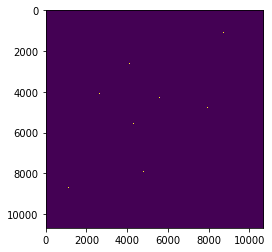

In [32]:
for i in range(0,edges.shape[0]):
    adjacency_matrix[edges[i,0], edges[i,1]] = 1
    adjacency_matrix[edges[i,1], edges[i,0]] = 1
#np.sum(adjacency_matrix)
plt.imshow(adjacency_matrix)

## Create Laplacian Matrix

In [33]:
laplacian = csgraph.laplacian(adjacency_matrix, normed=True)
np.sum(laplacian)

6543.449587739675

## Alternative way for the Laplacian Matrix

degrees = np.sum(adjacency_matrix, axis=0)
L_normed = np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L_normed[i,j] = -1.0/(np.sqrt(degrees[i]*degrees[j]))

degrees = np.sum(adjacency_matrix, axis=0)
L = degrees * np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L[i,j] = -1

np.sum(L_normed)

## Eigen-decomposition

_w, _v = np.linalg.eig(L_normed)

In [34]:
w, v = eigsh(laplacian, k, which="SA")
print(v)

[[ 4.76709626e-03  1.30396227e-03 -1.89721565e-04  9.74708774e-04
  -4.82251652e-04]
 [ 8.25685294e-03  2.13495777e-03 -2.42231044e-04  1.64147762e-03
  -6.82503355e-04]
 [ 6.74169219e-03  1.75407211e-03 -1.91021914e-04  1.25075603e-03
  -6.11907926e-04]
 ...
 [ 4.76709626e-03 -6.74576632e-04  1.62765635e-03 -3.69444259e-03
  -4.07655485e-04]
 [ 6.74169219e-03 -1.15292280e-03  2.41577874e-03 -5.11299999e-03
  -9.52862994e-05]
 [ 4.76709626e-03  1.71660758e-03  2.28542009e-04  2.41422009e-03
   4.47822326e-06]]


plt.plot(w)
plt.show()

## Selects second smallest eigenvalue and corresponding eigenvector

In [35]:
eig_val_idx = np.argpartition(w,k-1)[1]
eig_val_idx
eig_vec = v[:,eig_val_idx]

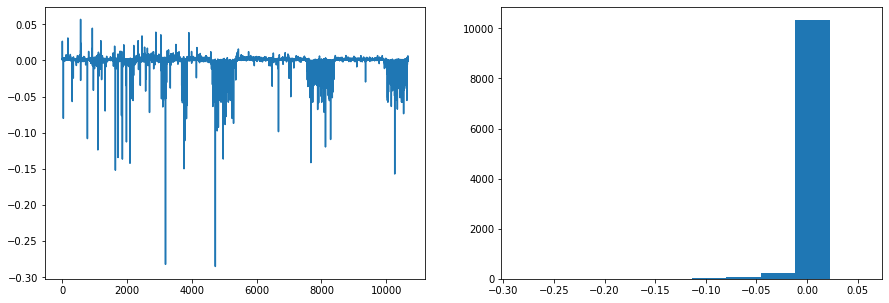

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(eig_vec)
plt.subplot(1, 2, 2)
plt.hist(eig_vec)
plt.show()

## K-means clustering

Should be improved to enforce balanced cluster sizes

In [37]:
whitened = whiten(v)
k_means, distortion = kmeans(v,k)
print(k_means)

[[ 0.00616969  0.00497717 -0.05998401 -0.00950376  0.00408841]
 [ 0.00912236 -0.00318774  0.00429321 -0.01029181 -0.00014682]
 [ 0.00699087  0.00146283  0.0001006   0.00103615 -0.00074585]
 [ 0.0118788   0.00543525  0.00181196  0.03025675  0.0229806 ]
 [ 0.00732092 -0.05177159 -0.0060033   0.00982565  0.00138034]]


## Select cluster for all vertices

In [38]:
def cluster(node, k_means):
    node_cluster = 0
    node_distance = np.linalg.norm(node - k_means[0,:])
    
    for i in range(1,k_means.shape[0]):
        tmp_distance = np.linalg.norm(node - k_means[i,:])
        if (tmp_distance < node_distance):
            node_distance = tmp_distance
            node_cluster = i
                
    return node_cluster
        

In [39]:
clusters = np.zeros((num_nodes,1))
for j in range(clusters.size):
    clusters[j] = cluster(v[j,:], k_means)

In [40]:
unique, counts = np.unique(clusters, return_counts=True)

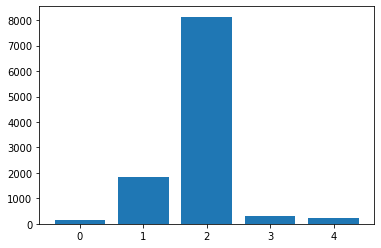

In [41]:
bars = np.arange(k)
plt.bar(bars, counts)
plt.show()

## Calculate cost for clusters

In [42]:
outer_edges = np.zeros((k,1))

for i in range(k):
    for j in range(num_edges):
        if(((clusters[edges[j,0]] == i) and (clusters[edges[j,1]] != i))
        or ((clusters[edges[j,0]] != i) and (clusters[edges[j,1]] == i))):
            outer_edges[i] += 1

In [43]:
counts = counts.reshape(k,-1)
costs = outer_edges / counts
cost = sum(costs)
print(outer_edges,"\n\n" ,  costs,"\n\n", cost)            

[[  66.]
 [2176.]
 [9661.]
 [7980.]
 [  83.]] 

 [[ 0.39759036]
 [ 1.19037199]
 [ 1.18743854]
 [26.07843137]
 [ 0.35470085]] 

 [29.20853312]


In [44]:
all_edges = np.zeros((k,1))

for i in range(k):
    for j in range(num_edges):
        if((clusters[edges[j,0]] == i) or (clusters[edges[j,1]] == i)):
            all_edges[i] +=1
print(all_edges)

[[  257.]
 [ 6510.]
 [16309.]
 [ 8493.]
 [  416.]]


## Output clusters

In [45]:
#out_file = open("./results/" + file + ".output" + ".txt", "w")
out_file = open("./results/" + file + ".output", "w")
out_file.write(first_line)
for i in range (num_nodes):
    out_file.write(str(i) + " " + str(int(clusters[i,0])) + "\n")
out_file.close()